 ![bse_logo_textminingcourse](https://bse.eu/sites/default/files/bse_logo_small.png)

# Computational Learning and Deep Learning 
## Project 1 Probability of Death of ICU Patients

by Natalia Beltrán

### Project Objective
<p>Throughout this project, I employed the MIMIC III dataset to forecast patients' mortality probability, employing the K-Nearest Neighbor (KNN) and Support Vector Machine (SVM) models. The expansive dataset comprises deidentified health records from over forty thousand patients who were admitted to ICU units
at the Beth Israel Deaconess Medical Center between 2001 and 2012.


**Train & Test Data Variable Breakdown**

Submission variables:
+ ID: icustay_id
+ Target: HOSPITAL_EXPIRE_FLAG


Variables Deleted from the start: 
<br>

The following variables contain data that wouldn't have been available on the first day of admission, and thus, they were excluded from the initial modeling phase of the project. In particular,  the "*DIAGNOSIS*" variable requires natural language processing. Given that "*ICD9_diagnosis*" offers a simpler numerical code for these written diagnosis, including the *"DIAGNOSIS"* variable seemed redundant. 


+ *DOD*: Date of Death 
+ *DEATHTIME*: Death Datetime
+ *DISCHTIME*: Discharge datetime 
+ *LOS*: Length of stay (days) 
+ *DIAGNOSIS*: Diagnosis

<p>Numerical variables:

+ *SysBP_Min/SysBP_Max/SysBP_Mean*: Systolic blood pressure
+ *DiasBP_Min/DiasBP_Max/DiasBP_Mean*: Diastolic blood pressure
+ *MeanBP_Min/MeanBP_Max/MeanBP_Mean*: Mean blood pressure
+ *RespRate_Min/RespRate_Max/RespRate_Mean*: Respiration cate
+ *TempC_Min/TempC_Max/TempC_Mean*: Temperature celsius
+ *SpO2_Min/SpO2_Max/SpO2_Mean*: Oxygen
+ *Glucose_Min/Glucose_Max/Glucose_Mean*: Glucose
+ *DIFF*: Days to add to any datetime of this patient to become realistic datetimes
+ *DOB*: Date of birth 
+ *ADMITTIME*: Admission datetime

<p>Categorical variables:

+ *GENDER*: Gender
+ *ADMISSION_TYPE*: Type of admission
+ *INSURANCE*: Type of patient's insurance 
+ *RELIGION*: Religion 
+ *MARITAL_STATUS*: Marital status 
+ *ETHNICITY*: Ethnicity 
+ *ICD9_diagnosis* = most important ICD9 diagnosis code for this ICU stay
+ *FIRST_CAREUNI*: Fisrt ICU unit assigned to this patient

**Extra Metadata Breakdown**

+ SUBJECT_ID: Patient identifier
+ HADM_ID: Hospital stay identifier 
+ SEQ_NUM: Number of Diagnosis for a given visit and person	
+ ICD9_CODE: Diagnosis code that reflect the patients suspected illness at each visit


 

## Loading Data
### Imports 

In [1]:
# Import packages
from helper_functions import *
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
import ipywidgets
from math import floor, ceil
import random
import time
from sklearn import preprocessing
import matplotlib.pylab as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix
# Load k-NN from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Load SVM
from sklearn.svm import SVC
import category_encoders as ce 
from category_encoders import OneHotEncoder 
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


### Data 

In [2]:
# Loading train, test, extra data
df_train = pd.read_csv('mimic_train.csv')
df_test = pd.read_csv('mimic_test_death.csv')
df_metadata = pd.read_csv('MIMIC_diagnoses.csv')

In [3]:
# Deletion of unused columns
###### TRAIN #########
delete_column_train = ['DOD', 'DISCHTIME', 'DEATHTIME', 'LOS', 'DIAGNOSIS'] 
df_train = df_train.drop(columns=delete_column_train)
print("Columns Train:")
print(df_train.columns) # final list of train columns 


###### TEST #########
delete_column_test = ['DIAGNOSIS'] 
df_test = df_test.drop(columns=delete_column_test)
print("Columns Test:")
print(df_test.columns) # final list of test columns

Columns Train:
Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'ADMITTIME', 'Diff', 'ADMISSION_TYPE',
       'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'ICD9_diagnosis', 'FIRST_CAREUNIT'],
      dtype='object')
Columns Test:
Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max

In [4]:
# List of numerical and categorical variables 
num_val = ['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean']

cat_val = ['GENDER','INSURANCE', 'ADMISSION_TYPE','FIRST_CAREUNIT','RELIGION', 'MARITAL_STATUS','ETHNICITY']

## Exploratory Data Analysis

Numerical variables seem to have a large number of missing for both train and test. To gain a deeper understanding of these variables, I will examine the proportion of missing values during *Section 3: Pre-Processing*. This will help determine whether imputation or deletion of variables is necessary for further processing.  

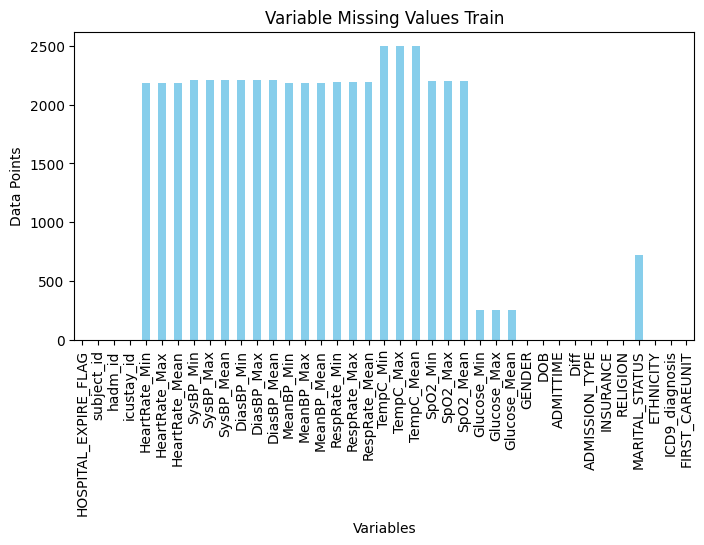

In [5]:
# Count of missing values train 
missing_val = df_train.isnull().sum()

plt.figure(figsize=(8, 4))
missing_val.plot(kind='bar', color='skyblue')
plt.title('Variable Missing Values Train')
plt.xlabel('Variables')
plt.ylabel('Data Points')
plt.show()

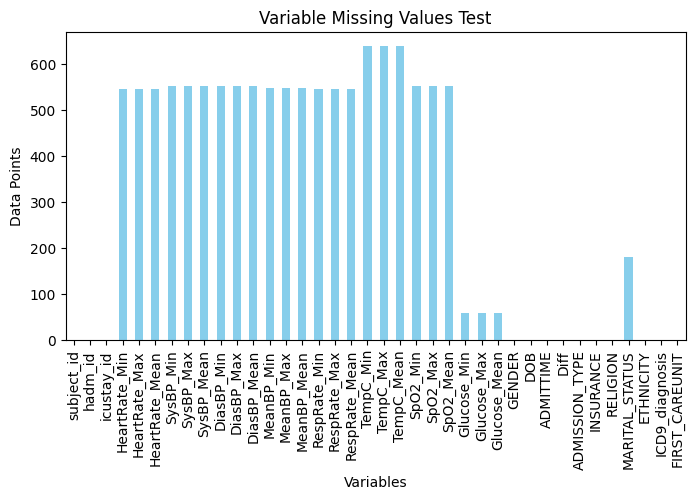

In [6]:
# Count of missing values train 
missing_val = df_test.isnull().sum()

plt.figure(figsize=(8,4))
missing_val.plot(kind='bar', color='skyblue')
plt.title('Variable Missing Values Test')
plt.xlabel('Variables')
plt.ylabel('Data Points')
plt.show()

<p>Outliers: 
<br>
<br>
During analysis of the training dataset, outliers were identified. However, upon addressing them, it became evident that they significantly influence the model's predictability. Notably, variables such as HeartRate, SysBP, DiasBP, MeanBP, RespRate, TempC, SpO2_Min, and SpO2 exhibited outliers. Interestingly, these outliers, particularly the higher values, demonstrate strong predictive capabilities for mortality rates. This observation is logical; for instance, elevated HeartRate might indicate a potential heart attack, making such values crucial indicators for mortality rates. Therefore, treating these variables with log transformation or Windsorizing could inadvertently remove these important indicators from our model. 

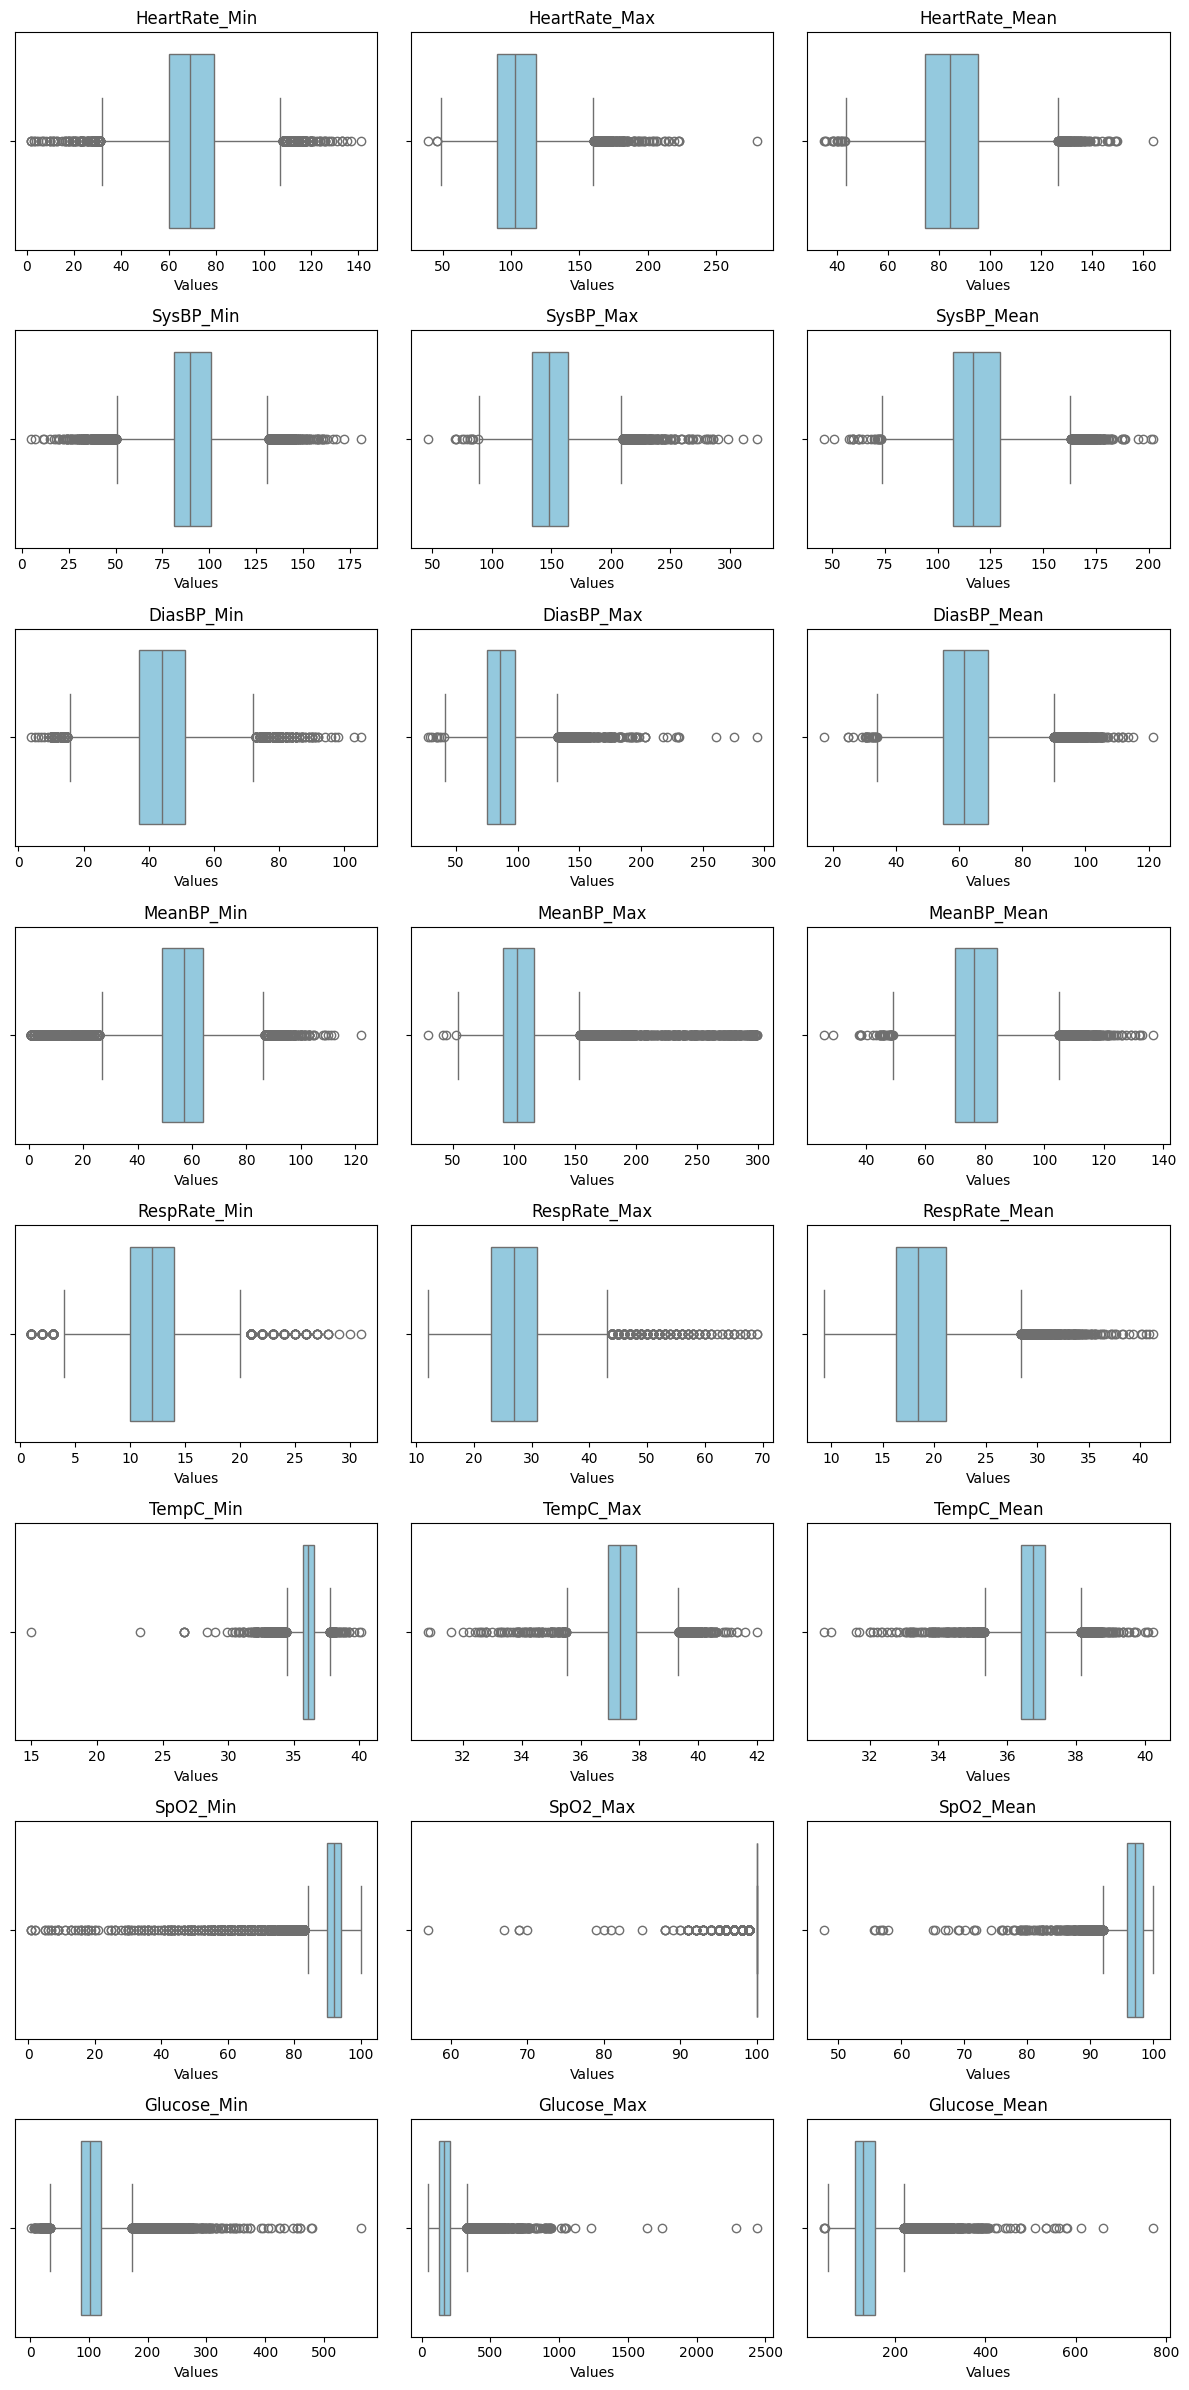

In [7]:
# Plotting the numerical values to check for outliers
num_rows = (len(num_val) + 2) // 3
num_cols = 3 

# Subpltos
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))
axes = axes.flatten()

#boxplot for each of my numerical values
for i, var in enumerate(num_val):
    sns.boxplot(x=df_train[var], ax=axes[i], color='skyblue')
    axes[i].set_title(var)
    axes[i].set_xlabel('Values')
    axes[i].set_ylabel('')

#Hide empty subplot
for j in range(len(num_val), num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Mean number of disease diagnoses: 11.038388497015735


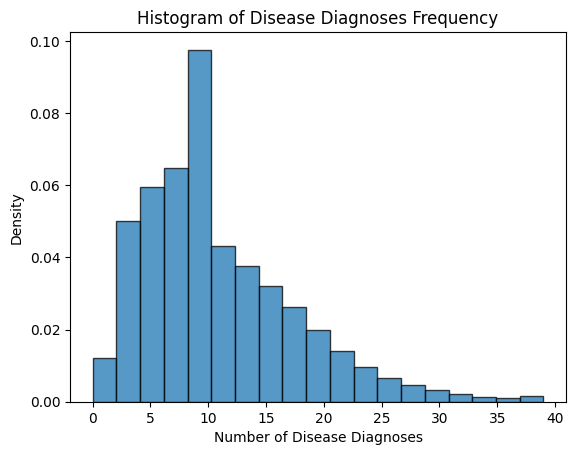

In [8]:
diagnosis_counts = df_metadata.groupby(['SUBJECT_ID', 'HADM_ID'])['SEQ_NUM'].nunique()

plt.hist(diagnosis_counts, bins=19, density=True, edgecolor='black', alpha=0.75)  # Set the number of bins to 19
plt.xlabel('Number of Disease Diagnoses')
plt.ylabel('Density')
plt.title('Histogram of Disease Diagnoses Frequency')

# Mean of Diagnosis
mean_diagnosis_count = diagnosis_counts.mean()
print("Mean number of disease diagnoses:", mean_diagnosis_count)


## Pre-Processing 

In [9]:
df_train.head() 

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,ICD9_diagnosis,FIRST_CAREUNIT
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,2108-07-16 00:00:00,2178-02-06 10:35:00,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,5789,MICU
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,2087-01-16 00:00:00,2129-02-12 22:34:00,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,53013,MICU
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,2057-09-17 00:00:00,2125-11-17 23:04:00,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,56983,MICU
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,2056-02-27 00:00:00,2131-01-26 08:00:00,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,5533,SICU
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,2066-12-19 00:00:00,2146-05-04 02:02:00,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,56211,TSICU


In [10]:
df_test.head()

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,DOB,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,ICD9_diagnosis,FIRST_CAREUNIT
0,64058,146725,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,...,2114-08-07 00:00:00,2196-02-23 11:45:00,-67454.42740,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,4241,CSRU
1,55871,108789,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,...,2055-06-04 00:00:00,2103-10-22 23:58:00,-34204.08546,EMERGENCY,Private,NOT SPECIFIED,MARRIED,WHITE,25013,MICU
2,42892,139885,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,...,2073-04-21 00:00:00,2115-06-28 07:15:00,-38710.61714,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,5920,MICU
3,66629,173017,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,...,2078-04-14 00:00:00,2162-08-01 21:00:00,-54902.54313,EMERGENCY,Private,EPISCOPALIAN,WIDOWED,WHITE,82120,CCU
4,79851,171573,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,...,2050-01-17 00:00:00,2103-01-16 22:05:00,-33906.93488,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,51884,MICU


In [11]:
df_train.shape

(20885, 39)

In [12]:
df_train.dtypes

HOSPITAL_EXPIRE_FLAG      int64
subject_id                int64
hadm_id                   int64
icustay_id                int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
DOB                      object
ADMITTIME                object
Diff    

#### Numerical Variables 

From ***Section 2. Exploratory Data Analysis*** I observed a considerable number of missing values across both numerical variables and a singular categorical variable in both my train and test datasets. Upon examining 
the proportion of missing values in the numerical variables, I found it to be ***approximately ~ 0.105***. Given this is relatively small proportion, I concluded that it was not substantial enough to warrant the removal of any of those columns and opted to proceed with imputation. 

In [5]:
# TRAIN 
nulls_train = df_train[num_val].isnull().mean()
print("Null values of train data set:", nulls_train) 

# TEST 
nulls_test = df_test[num_val].isnull().mean()
print("Null values of test data set:", nulls_test) 

Null values of train data set: HeartRate_Min     0.104716
HeartRate_Max     0.104716
HeartRate_Mean    0.104716
SysBP_Min         0.105722
SysBP_Max         0.105722
SysBP_Mean        0.105722
DiasBP_Min        0.105770
DiasBP_Max        0.105770
DiasBP_Mean       0.105770
MeanBP_Min        0.104668
MeanBP_Max        0.104668
MeanBP_Mean       0.104668
RespRate_Min      0.104812
RespRate_Max      0.104812
RespRate_Mean     0.104812
TempC_Min         0.119559
TempC_Max         0.119559
TempC_Mean        0.119559
SpO2_Min          0.105482
SpO2_Max          0.105482
SpO2_Mean         0.105482
Glucose_Min       0.012114
Glucose_Max       0.012114
Glucose_Mean      0.012114
dtype: float64
Null values of test data set: HeartRate_Min     0.104386
HeartRate_Max     0.104386
HeartRate_Mean    0.104386
SysBP_Min         0.105535
SysBP_Max         0.105535
SysBP_Mean        0.105535
DiasBP_Min        0.105727
DiasBP_Max        0.105727
DiasBP_Mean       0.105727
MeanBP_Min        0.104769
MeanBP

<P> During the evaluation of the different imputation techniques (including KNNImputer, IterativeImputer, mean imputing) through grid searching and AUC score analysis, I became concerned about the potential for overfitting, particularly with KNNImputer and IterativeImputer. Given the intricate use of Target Encoding across multiple columns in the dataset, I hypothesized that these imputation methods might interact unpredictably with the encoded features, potentially leading to overfitting issues. 

To deal with these concerns, I opted to refrain from utilizing KNNImputer and IterativeImputer. Instead, I ***opted for mean imputation***, which provided satisfactory AUC scores during modeling and minimized the risk of introducing bias or overfitting due to the extensive process of the Target Encoding. Furthermore, given the small proportion of missing values relative to the dataset size, I am confident in proceeding with a simpler imputation method such as mean imputation.

In [5]:
# Imputations of Numerical Variables 

###### TRAIN #########
# MEAN TRAIN 
for column in num_val: 
    if df_train[column].isnull().sum() > 0: 
        mean_value = df_train[column].mean()
        df_train[column].fillna(mean_value, inplace=True)
        
###### TEST #########
for column in num_val: 
    if df_test[column].isnull().sum() > 0: 
        mean_value = df_train[column].mean()
        df_test[column].fillna(mean_value, inplace=True)

# Checking that imputation went smoothly
###### TRAIN #########
print("Train check NO nulls numerical:")
print(df_train[num_val].isna().sum().sum())
###### TEST #########
print("Test check NO nulls numerical:") 
print(df_test[num_val].isna().sum().sum())

Train check NO nulls numerical:
0
Test check NO nulls numerical:
0


### Categorical Variables 

As previously noted, a categorical variable exhibited a notable amount of missing values. The variable of ***MARITAL_STATUS*** contains only a few observations with NaNs (3.457%) for the Train dataset and NaNs (3.447%) for the test dataset. The proportion of missing values within this category variable was sufficiently low, rendering removal unnecessary. To address these missing value, ***the mode imputation*** was utilized. 

In [6]:
# Checking for proportion of missing value for the categorical variables 
###### TRAIN #########
print("Train checking for nulls in categorical:")
print(df_train[cat_val].isnull().mean())
###### TEST #########
print("Test checking for nulls in categorical:") 
print(df_test[cat_val].isnull().mean())

Train checking for nulls in categorical:
GENDER            0.00000
INSURANCE         0.00000
ADMISSION_TYPE    0.00000
FIRST_CAREUNIT    0.00000
RELIGION          0.00000
MARITAL_STATUS    0.03457
ETHNICITY         0.00000
dtype: float64
Test checking for nulls in categorical:
GENDER            0.000000
INSURANCE         0.000000
ADMISSION_TYPE    0.000000
FIRST_CAREUNIT    0.000000
RELIGION          0.000000
MARITAL_STATUS    0.034476
ETHNICITY         0.000000
dtype: float64


##### Marital Status 

In [7]:
###### TRAIN #########
marital_mode = df_train['MARITAL_STATUS'].mode()[0]
df_train['MARITAL_STATUS'].fillna(marital_mode, inplace=True)
###### TEST #########
df_test['MARITAL_STATUS'].fillna(marital_mode, inplace=True)

Upon additional research into certain variables, it seemed that some variables held potentially significant importance as features for modeling. Notably those with religious affiliations or ethinicity could offer valuable insights as different cultural backgrounds may influence towards receiving medical assistance. 

##### Unique values (Categorical variables)

In [8]:
# Get unique values of my categorical columns for dummy encoding 
###### TRAIN #########
print("Train Categorical Unique Values:")
for column in cat_val: 
    unique_val = df_train[column].unique()
    print(f"{column}': {unique_val}")

###### TEST #########
print("Test Categorical Unique Values:")
for column in cat_val: 
    unique_val = df_test[column].unique()
    print(f"{column}': {unique_val}")

Train Categorical Unique Values:
GENDER': ['F' 'M']
INSURANCE': ['Medicare' 'Private' 'Medicaid' 'Self Pay' 'Government']
ADMISSION_TYPE': ['EMERGENCY' 'ELECTIVE' 'URGENT']
FIRST_CAREUNIT': ['MICU' 'SICU' 'TSICU' 'CSRU' 'CCU']
RELIGION': ['PROTESTANT QUAKER' 'UNOBTAINABLE' 'NOT SPECIFIED' 'JEWISH' 'CATHOLIC'
 'OTHER' 'BUDDHIST' 'EPISCOPALIAN' 'ROMANIAN EAST. ORTH' 'GREEK ORTHODOX'
 "JEHOVAH'S WITNESS" 'MUSLIM' 'CHRISTIAN SCIENTIST' 'HINDU'
 '7TH DAY ADVENTIST' 'UNITARIAN-UNIVERSALIST' 'HEBREW']
MARITAL_STATUS': ['SINGLE' 'MARRIED' 'SEPARATED' 'WIDOWED' 'DIVORCED' 'UNKNOWN (DEFAULT)'
 'LIFE PARTNER']
ETHNICITY': ['WHITE' 'BLACK/AFRICAN AMERICAN' 'BLACK/CAPE VERDEAN'
 'UNKNOWN/NOT SPECIFIED' 'PATIENT DECLINED TO ANSWER'
 'ASIAN - ASIAN INDIAN' 'OTHER' 'HISPANIC/LATINO - PUERTO RICAN' 'ASIAN'
 'HISPANIC OR LATINO' 'UNABLE TO OBTAIN' 'BLACK/HAITIAN'
 'WHITE - OTHER EUROPEAN' 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER'
 'WHITE - RUSSIAN' 'WHITE - EASTERN EUROPEAN' 'ASIAN - CHINESE'
 'HISPAN

##### **Religion** 
Some incosistencies were observed in the unique values between the train and test datasets. To ensure consistency and maintain the same number of columns during OneHotEncoding, certain unique values were replaced to share identical names across both datasets. This was done to preserve uniformity in dataset shapes and create a seamless encoding process. 

In [9]:
# For Religion columns has several names for other, will be merging them together into 1. 

###### TRAIN #########
val_reli_merge = ['UNOBTAINABLE', 'NOT SPECIFIED']
df_train['RELIGION'].replace(val_reli_merge, 'NOT SPECIFIED',inplace=True)

# Train data set has Hebrew unique value but train does not 
# making sure to replace the name so its the same on both datasets to then one hot encode 
val_reli_merge_2 = ['HEBREW']
df_train['RELIGION'].replace(val_reli_merge_2, 'JEWISH',inplace=True)

###### TEST #########
df_test['RELIGION'].replace(val_reli_merge,'NOT SPECIFIED',inplace=True)
df_test['RELIGION'].replace(val_reli_merge_2, 'JEWISH',inplace=True)

##### **Ethnicity** 
In order to reduce dimensionality when OneHotEncoding, several ethnicities were grouped into specific categories consolidating the number of columns. Groups were formed based on similarities in ethnic backgrounds such as Hispanics, Asian, etc.., leveraging existing labels for unique names. If there was no clear grouping criterion, those ethinicites remained as individual groups. This consolidation reduced the original count of over 20 distinct columns to just 10 ethnicity categories creating a more concise representation of the dataset. 

In [10]:
ethnicity_map = {'WHITE':['WHITE','WHITE - OTHER EUROPEAN','WHITE - RUSSIAN', 'WHITE - EASTERN EUROPEAN', 
                          'WHITE - BRAZILIAN'],

'BLACK' :['BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN', 'BLACK/AFRICAN'],

'OTHER' : ['UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER', 'UNABLE TO OBTAIN'],

'ASIAN' :['ASIAN - ASIAN INDIAN', 'ASIAN', 'ASIAN - CHINESE', 'ASIAN - VIETNAMESE',
         'ASIAN - KOREAN','ASIAN - OTHER', 'ASIAN - THAI', 'ASIAN - FILIPINO',
           'ASIAN - CAMBODIAN', 'ASIAN - JAPANESE' ]  ,

'HISPANIC' :['HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC OR LATINO', 'HISPANIC/LATINO - CUBAN',
             'PORTUGUESE', 'SOUTH AMERICAN', 'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - GUATEMALAN',
             'HISPANIC/LATINO - DOMINICAN', 'HISPANIC/LATINO - COLOMBIAN', 
             'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)', 'HISPANIC/LATINO - HONDURAN',
             'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)' 'HISPANIC/LATINO - HONDURAN','HISPANIC/LATINO - MEXICAN' ] ,

'NATIVE ALASKA' : ['AMERICAN INDIAN/ALASKA NATIVE', 'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']}

def map_ethnicity(ETHNICITY):
    for category, ethnicities in ethnicity_map.items():
        if ETHNICITY in ethnicities:
            return category
    return ETHNICITY

###### TRAIN #########
df_train['ETHNICITY'] = df_train['ETHNICITY'].apply(map_ethnicity)

###### TEST #########
df_test['ETHNICITY'] = df_test['ETHNICITY'].apply(map_ethnicity)

#### OneHotEncoding

In [11]:
# Encoding categorical to get dummy variables
one_hot_dummy = ce.OneHotEncoder(cols=cat_val, return_df=True)
###### TRAIN #########
df_train= one_hot_dummy.fit_transform(df_train)
###### TEST #########
df_test = one_hot_dummy.fit_transform(df_test)

Analyzing the first care unit we can see an association with the care unit with the mortality rate, which in a medical context would make sense as different diseases will be placed in different units depending on severity. As patients in the CCU will have more extreme and intense deaseses compared to those who are more intermediate care units. 

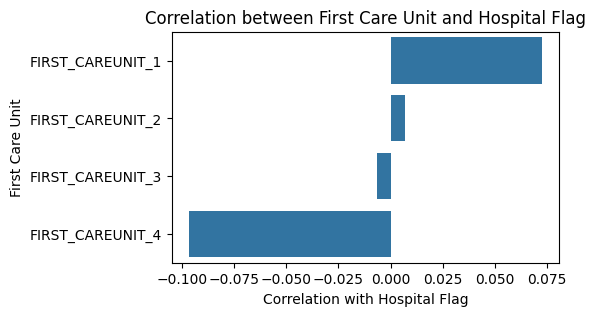

In [12]:
correlations = df_train[['FIRST_CAREUNIT_1', 'FIRST_CAREUNIT_2', 'FIRST_CAREUNIT_3', 'FIRST_CAREUNIT_4', 'FIRST_CAREUNIT_4']].corrwith(df_train['HOSPITAL_EXPIRE_FLAG'])

# Plot the associations
plt.figure(figsize=(5, 3))
sns.barplot(x=correlations.values, y=correlations.index, orient='h')
plt.xlabel('Correlation with Hospital Flag')
plt.ylabel('First Care Unit')
plt.title('Correlation between First Care Unit and Hospital Flag')
plt.show()

#### Feature Engineering 

The dataset did not include patients' age directly; instead, it provided variables such as  "**DOB**", "**ADMITTIME**" and "**DIFF**" but is a crucial variable in medical contexts. To derive the "**AGE**" variable, I utilized the date of birth and the diff to establish realistic datetime values. Similarly, I processed the admission time into the hospital using the diff variable. Once the datetime values were adjusted realistically, I computed the age of the patient. Subsequently, I removed the original columns containing the DOB, ADMITTIME, and DIFF.  

In [12]:
###### TRAIN #########
df_train['DOB'] = pd.to_datetime(df_train['DOB'])
df_train['ADMITTIME'] = pd.to_datetime(df_train['ADMITTIME'])
df_train['Diff'] = pd.to_timedelta(df_train['Diff'], unit='D')

# Calculation of AGE using DOB, ADMITTIME, DIFF
df_train['Adjusted_DOB'] = df_train['DOB'] + df_train['Diff']
df_train['Adjusted_ADMITTIME'] = df_train['ADMITTIME'] + df_train['Diff']

df_train['Adjusted_DOB'] = pd.to_datetime(df_train['Adjusted_DOB'])
df_train['Adjusted_ADMITTIME'] = pd.to_datetime(df_train['Adjusted_ADMITTIME'])

df_train['AGE'] = df_train['Adjusted_ADMITTIME'].dt.year - df_train['Adjusted_DOB'].dt.year

df_train.drop(columns = ['DOB', 'ADMITTIME', 'Adjusted_DOB','Adjusted_ADMITTIME', 'Diff'], inplace = True)


###### TEST #########
df_test['DOB'] = pd.to_datetime(df_test['DOB'])
df_test['ADMITTIME'] = pd.to_datetime(df_test['ADMITTIME'])
df_test['Diff'] = pd.to_timedelta(df_test['Diff'], unit='D')

# Calculation of AGE using DOB, ADMITTIME, DIFF
df_test['Adjusted_DOB'] = df_test['DOB'] + df_test['Diff']
df_test['Adjusted_ADMITTIME'] = df_test['ADMITTIME'] + df_test['Diff']

df_test['Adjusted_DOB'] = pd.to_datetime(df_test['Adjusted_DOB'])
df_test['Adjusted_ADMITTIME'] = pd.to_datetime(df_test['Adjusted_ADMITTIME'])

df_test['AGE'] = df_test['Adjusted_ADMITTIME'].dt.year - df_test['Adjusted_DOB'].dt.year

df_test.drop(columns = ['DOB', 'ADMITTIME', 'Adjusted_DOB','Adjusted_ADMITTIME', 'Diff'], inplace = True)

Upon examination of the *"AGE"* variable, it became apparent that the ages of older patients had been encrypted for most likely data protection purposes. Patients aged 89 or above had their ages manipulated to excessively large values (e.g., 310 years old). Determining the original age of the oldest patient posed a challenge, and simply adding the mean age of the entire dataset would not be realistic to the patients original age. Moreover, assigning an age below 89 could potentially affect modeling outcomes, given the significance of age in medical assistance considerations. 

In [13]:
df_train['AGE'].describe()

count    20885.000000
mean        75.376969
std         55.671475
min         15.000000
25%         53.000000
50%         66.000000
75%         78.000000
max        310.000000
Name: AGE, dtype: float64

To address the issue of the encryption, I opted to impute the value of 95 to all ages above 89. This approach aims to provide patients with encrypted ages a value closer to their original age at the time of hospital admission, thereby maintaining the integrity of the dataset while preserving the importance of age as a predictive feature. 

In [14]:
###### TRAIN #########
df_train.loc[df_train['AGE'] > 89, 'AGE'] = int(95)  
df_train['AGE']
###### TEST #########
df_test.loc[df_test['AGE'] > 89, 'AGE'] = int(95)
df_test['AGE']

0       82
1       49
2       42
3       85
4       53
        ..
5216    59
5217    76
5218    81
5219    78
5220    62
Name: AGE, Length: 5221, dtype: int32

#### Target Encoding ICD9_diagnosis

The variable "ICD9_diagnosis" contains the final diagnosis assigned to each patient, a feature that holds significant predictive value due to its strong correlation with patient mortality rates. However, the large number of unique diagnosis codes poses a challenge for traditional encoding methods like OneHotEncoding, as it would substantially increase the dimensionality of the dataset, potentially impeding model performance.
<p> To address this challenge, I chose to utilize TargetEncoding from the category_encoder package to create probabilities for the diagnosis codes. TargetEncoding offers a more efficient representation of categorical variables by encoding them based on the target variable's mean within each category. However, to mitigate the risk of overfitting associated with TargetEncoding, so I incorporated a smoothing technique.

<p>After experimenting with different smoothing parameter values, a value of 10 was determined to be optimal for the final model. This choice was based on its ability to yield the best results in terms of the final AUC score, ensuring effective encoding of the diagnosis codes while maintaining model robustness against overfitting.

In [15]:
###### TRAIN #########
encoder_code = ce.TargetEncoder(smoothing=10)
df_train['ICD9_diagnosis_encoded'] = encoder_code.fit_transform(df_train['ICD9_diagnosis'], df_train['HOSPITAL_EXPIRE_FLAG'])
df_train.drop(['ICD9_diagnosis'], axis=1, inplace=True)

###### TEST #########
df_test['ICD9_diagnosis_encoded'] = encoder_code.transform(df_test['ICD9_diagnosis'])
df_test.drop(['ICD9_diagnosis'], axis=1, inplace=True)

In [16]:
# Final check that the datasets have been imputated and encoded properly 
sum_train = df_train.isna().sum().sum()
sum_test = df_test.isna().sum().sum()

print("Sum total NaNs after imputation Train", sum_train)
print("Sum total NaNs after imputation Test", sum_test)

Sum total NaNs after imputation Train 0
Sum total NaNs after imputation Test 0


#### Extra Metadata Incorporation

From ***Section 2: Exploratoy Data Analysis***, I recognized the valuable information contained in the metadata regarding various diagnoses for the patients. To harness this information effectively, I opted to merge the unique combinations of the SUBJECT_ID and HADM_ID variables, creating a new dataframe with these combinations. Subsequently, I generated columns to capture the different numbers of diagnoses (DEQ_NUM) and their respective codes.

Similar to the challenge encountered with the ICD9_diagnosis variable, the SEQ_NUM values also required TargetEncoding for encoding. However, applying TargetEncoding directly would inflate the dimensionality of the dataset. To address this issue, I referred to the *Histogram of Disease Diagnoses Frequency* figure, which revealed that the mean number of diagnoses is approximately 11. Leveraging this insight, I selected the top 11 diagnoses as a reference, effectively reducing the dimensionality of the model.

In [17]:
top_11 = df_metadata['SEQ_NUM'].value_counts().head(11).index.tolist()

In [18]:
df_metadata_11 = df_metadata[df_metadata['SEQ_NUM'].isin(top_11)]


In [19]:
grouped = df_metadata_11.groupby(['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM'])['ICD9_CODE'].first().unstack()


In [20]:
# Reorgonazing the data to create the top 11 SEQ_NUM for the unique combinations 
grouped.columns = [f'SEQ_NUM_{col}' for col in grouped.columns]
grouped

,,SEQ_NUM_1.0,SEQ_NUM_2.0,SEQ_NUM_3.0,SEQ_NUM_4.0,SEQ_NUM_5.0,SEQ_NUM_6.0,SEQ_NUM_7.0,SEQ_NUM_8.0,SEQ_NUM_9.0,SEQ_NUM_10.0,SEQ_NUM_11.0
SUBJECT_ID,HADM_ID,,,,,,,,,,,
2,163353,V3001,V053,V290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,145834,0389,78559,5849,4275,41071,4280,6826,4254,2639,NaN,NaN
4,185777,042,1363,7994,2763,7907,5715,04111,V090,E9317,NaN,NaN
5,178980,V3000,V053,V290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,107064,40391,4440,9972,2766,2767,2859,2753,V1582,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
99985,176670,0389,51881,48241,4870,78552,V4281,99592,2449,2724,2859,53081
99991,151118,56211,0389,5570,5849,99592,56081,78959,5538,7885,40291,4280
99992,197084,9999,56881,5772,2851,5849,5799,72992,53081,4019,2721,5699


In [21]:
# Merging reorganized metadata with the train dataset 
###### TRAIN #########
df_train = pd.merge(df_train, grouped, how='left', left_on=['subject_id', 'hadm_id'], right_on=['SUBJECT_ID', 'HADM_ID'])
df_train

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,SEQ_NUM_2.0,SEQ_NUM_3.0,SEQ_NUM_4.0,SEQ_NUM_5.0,SEQ_NUM_6.0,SEQ_NUM_7.0,SEQ_NUM_8.0,SEQ_NUM_9.0,SEQ_NUM_10.0,SEQ_NUM_11.0
0,0,55440,195768,228357,89.000000,145.000000,121.043478,74.000000,127.00000,106.586957,...,51881,41071,42831,42732,2851,53550,79092,4280,42731,42789
1,0,76908,126136,221004,63.000000,110.000000,79.117647,89.000000,121.00000,106.733333,...,9351,E915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,95798,136645,296315,81.000000,98.000000,91.689655,88.000000,138.00000,112.785714,...,56729,5845,5789,5121,5119,56889,E8788,3310,29410,40390
3,0,40708,102505,245557,76.000000,128.000000,98.857143,84.000000,135.00000,106.972973,...,48242,5163,4280,53081,73300,2720,4019,2440,30000,311
4,0,28424,127337,225281,69.705904,105.239801,85.180250,91.110564,150.72592,119.145423,...,5185,9973,5180,9341,99859,6822,9971,42732,42832,E8788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,0,28043,135417,244530,65.000000,92.000000,78.500000,60.000000,160.00000,110.976190,...,3453,5849,51881,2762,99679,4538,42731,5968,78839,4589
20881,0,87605,191007,216116,74.000000,112.000000,89.156250,100.000000,150.00000,123.272727,...,3485,3484,7843,25000,36846,NaN,NaN,NaN,NaN,NaN
20882,0,47492,152608,274507,58.000000,97.000000,76.933333,94.000000,131.00000,112.037037,...,5990,E9323,4019,7140,53081,NaN,NaN,NaN,NaN,NaN
20883,0,62946,191485,225930,59.000000,102.000000,81.844444,96.000000,150.00000,123.837209,...,42823,9972,2930,99811,4111,2851,4423,E8790,71596,4019


In [22]:
# Merging reorganized metadata with the test dataset 
###### TEST #########
df_test = pd.merge(df_test, grouped, how='left', left_on=['subject_id', 'hadm_id'], right_on=['SUBJECT_ID', 'HADM_ID'])
df_test 

,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,SEQ_NUM_2.0,SEQ_NUM_3.0,SEQ_NUM_4.0,SEQ_NUM_5.0,SEQ_NUM_6.0,SEQ_NUM_7.0,SEQ_NUM_8.0,SEQ_NUM_9.0,SEQ_NUM_10.0,SEQ_NUM_11.0
0,64058,146725,208169,58.000000,90.000000,85.244898,77.000000,153.00000,98.490909,40.000000,...,43411,99811,2851,99702,E8782,41401,45829,42731,3682,3659
1,55871,108789,251754,91.000000,145.000000,115.055556,73.000000,143.00000,101.210526,42.000000,...,51881,78559,5845,4820,2760,4019,70703,70725,42789,V5867
2,42892,139885,242171,106.000000,132.000000,117.750000,93.000000,137.00000,116.222222,51.000000,...,03843,5990,99591,2869,99859,99811,340,59654,04185,27650
3,66629,173017,263035,72.000000,105.000000,83.627119,72.000000,168.00000,126.981818,39.000000,...,42832,5119,5180,2851,73313,4280,E8843,45829,41401,4019
4,79851,171573,279388,85.000000,124.000000,98.600000,86.000000,144.00000,110.666667,52.000000,...,48241,5119,75989,49121,42832,2639,99799,4168,42731,V462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,28941,107962,278087,63.000000,131.000000,97.130435,108.000000,140.00000,122.631579,49.000000,...,70703,51881,4592,4233,4238,7907,5990,00845,99674,5601
5217,27436,112243,266914,69.705904,105.239801,85.180250,91.110564,150.72592,119.145423,44.327854,...,5185,99811,9971,9974,5570,00845,5990,5119,42822,99832
5218,44232,156430,213413,74.000000,91.000000,81.488372,117.000000,171.00000,143.395349,48.000000,...,20280,2761,4580,55320,V1041,33829,NaN,NaN,NaN,NaN
5219,76544,148900,286384,70.000000,89.000000,80.276596,68.000000,137.00000,110.680851,42.000000,...,2851,9971,25000,4412,4241,4019,2724,3659,V1582,42731


In [23]:
# Smoothing value selected to treat the overfitting 
encoder = ce.TargetEncoder(smoothing=10, handle_missing='value') 

for col in df_train.columns:
    if col.startswith('SEQ_NUM_'):
        df_train[f'{col}_encoded'] = encoder.fit_transform(df_train[col], df_train['HOSPITAL_EXPIRE_FLAG'])
        df_test[f'{col}_encoded'] = encoder.transform(df_test[col])

In [24]:
seq_num_drop = ['SEQ_NUM_1.0', 'SEQ_NUM_2.0', 'SEQ_NUM_3.0',
'SEQ_NUM_4.0', 'SEQ_NUM_5.0', 'SEQ_NUM_6.0', 'SEQ_NUM_7.0',
'SEQ_NUM_8.0', 'SEQ_NUM_9.0', 'SEQ_NUM_10.0','SEQ_NUM_11.0' ]
###### TRAIN#########
df_train = df_train.drop(seq_num_drop, axis=1)
###### TEST #########
df_test = df_test.drop(seq_num_drop, axis=1)

## Standardizing  

In [25]:
scaler = preprocessing.StandardScaler()

#### Best feature selection

In [26]:
k_best = SelectKBest(score_func=f_classif, k=25)

X_best = df_train.drop(['HOSPITAL_EXPIRE_FLAG','subject_id', 'hadm_id', 'icustay_id'], axis=1)
y_best = df_train['HOSPITAL_EXPIRE_FLAG']  #target 
X_test = df_test.drop(['subject_id', 'hadm_id', 'icustay_id'], axis=1)

k_best.fit(X_best, y_best)

X_train_k_best = k_best.transform(X_best)
X_test_k_best = k_best.transform(X_test)

selected_feature_indices = k_best.get_support(indices=True)
selected_features = X_best.columns[selected_feature_indices]

print("Selected features:", selected_features)

Selected features: Index(['HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Mean',
       'DiasBP_Min', 'MeanBP_Min', 'MeanBP_Mean', 'RespRate_Max',
       'RespRate_Mean', 'TempC_Min', 'SpO2_Min', 'SpO2_Mean', 'AGE',
       'ICD9_diagnosis_encoded', 'SEQ_NUM_1.0_encoded', 'SEQ_NUM_2.0_encoded',
       'SEQ_NUM_3.0_encoded', 'SEQ_NUM_4.0_encoded', 'SEQ_NUM_5.0_encoded',
       'SEQ_NUM_6.0_encoded', 'SEQ_NUM_7.0_encoded', 'SEQ_NUM_8.0_encoded',
       'SEQ_NUM_9.0_encoded', 'SEQ_NUM_10.0_encoded', 'SEQ_NUM_11.0_encoded'],
      dtype='object')


In [27]:
trained = df_train[(selected_features)] # X train 
num_test=df_test[(selected_features)] # y train
y_train = df_train['HOSPITAL_EXPIRE_FLAG']  #target 

In [28]:
scaler.fit(trained)

StandardScaler()

In [29]:
# Apply the scaler to the training and testing datasets
X_train_scaled = scaler.transform(trained)
X_test_scaled = scaler.transform(num_test)

## Models 

### K-Nearest Neighbor

In [187]:
MyKNN = KNeighborsClassifier() 

#### Gridsearch - KNN

Previous Gridsearchs: 
+ grid_values = {'n_neighbors':[1, 10, 20, 40, 80, 100], 'weights':['uniform','distance', 'p': [1, 2]],  'algorithm':['kd_tree', 'brute' , 'ball_tree'] } 
    - Best: 
        - n_neighbors = 100 
        - weights = distance
        - p = 2
        - algorithm = kd_tree
+ grid_values = {'n_neighbors':[200, 250, 300, 350,400], 'weights':['uniform','distance'], 'p': [ 2], 'metric': ['euclidean', 'manhattan', 'minkowski'], 'algorithm'['kd_tree'] } 
    - Best: 
        - n_neighbors = 400 
        - weights = distance 
        - p = 2 
        - algorithm = kd_tree 
        - metric = minkowski
+ grid_values = {'n_neighbors':[400, 420, 440, 460, 480], 'weights':['uniform','distance'], 'p': [2], 'metric': ['minkowski'] } 
    - Best: 
        - n_neighbors = 400 
        - weights = distance 
        - p = 2 
        - algorithm = kd_tree 
        - metric = minkowski

Final Gridsearch: 
+ grid_values: 
    - 'n_neighbors':[455,460, 465,470] 
    - 'weights':['uniform','distance'] 
    - 'algorithm':['kd_tree']
    - 'metric': ['minkowski']   
    - 'p': [2] 


In [188]:
# Final Gridsearch 
grid_values = {'n_neighbors':[455,460, 465,470], 
               'weights':['uniform','distance'] , 
               'algorithm':['kd_tree'], 
               'metric': ['minkowski'],   
               'p': [2]  
 } 

In [189]:
#Grid Search
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

grid_knn_acc = GridSearchCV(MyKNN, param_grid = grid_values, scoring = 'roc_auc', cv=5) 

In [190]:
grid_knn_acc.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['kd_tree'], 'metric': ['minkowski'],
                         'n_neighbors': [455, 460, 465, 470], 'p': [2],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc')

best parameters: {'algorithm': 'kd_tree', 'metric': 'minkowski', 'n_neighbors': 460, 'p': 2, 'weights': 'distance'}
best score:      0.92565 (+/-0.00441)


,param_algorithm,param_metric,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,kd_tree,minkowski,460,2,distance,"{'algorithm': 'kd_tree', 'metric': 'minkowski'...",0.922505,0.921476,0.930312,0.931720,0.922261,0.925655,0.004413,1
1,kd_tree,minkowski,455,2,distance,"{'algorithm': 'kd_tree', 'metric': 'minkowski'...",0.922433,0.921591,0.930197,0.931671,0.922276,0.925634,0.004362,2
5,kd_tree,minkowski,465,2,distance,"{'algorithm': 'kd_tree', 'metric': 'minkowski'...",0.922416,0.921517,0.930327,0.931657,0.922206,0.925624,0.004413,3
7,kd_tree,minkowski,470,2,distance,"{'algorithm': 'kd_tree', 'metric': 'minkowski'...",0.922465,0.921406,0.930430,0.931556,0.921975,0.925566,0.004458,4
2,kd_tree,minkowski,460,2,uniform,"{'algorithm': 'kd_tree', 'metric': 'minkowski'...",0.920723,0.919802,0.928954,0.929418,0.920410,0.923861,0.004360,5
0,kd_tree,minkowski,455,2,uniform,"{'algorithm': 'kd_tree', 'metric': 'minkowski'...",0.920642,0.919937,0.928809,0.929414,0.920473,0.923855,0.004302,6
4,kd_tree,minkowski,465,2,uniform,"{'algorithm': 'kd_tree', 'metric': 'minkowski'...",0.920627,0.919804,0.928983,0.929368,0.920343,0.923825,0.004378,7
6,kd_tree,minkowski,470,2,uniform,"{'algorithm': 'kd_tree', 'metric': 'minkowski'...",0.920657,0.919675,0.929080,0.929281,0.920075,0.923754,0.004442,8


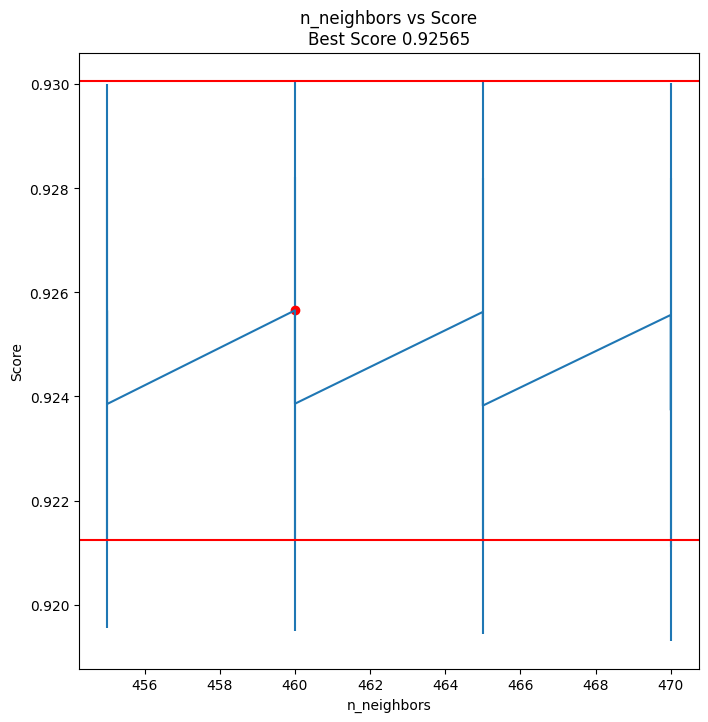

In [191]:
GridSearch_table_plot(grid_knn_acc, "n_neighbors", negative=False, display_all_params=False)

In [192]:
MyKNN_new = grid_knn_acc.best_estimator_
Target_pred_KNN_proba= MyKNN_new.predict_proba(X_test_scaled)

In [175]:
# Print shapes of the arrays
print('Shape of ID array:', df_test['icustay_id'].values.shape)
print('Shape of PredictedTarget array:', np.array(Target_pred_KNN_proba).shape)

# Print the types of the arrays 
print('Type of ID array:', type(df_test['icustay_id'].values))
print('Type of PredictedTarget array:', type(Target_pred_KNN_proba))

Shape of ID array: (5221,)
Shape of PredictedTarget array: (5221, 2)
Type of ID array: <class 'numpy.ndarray'>
Type of PredictedTarget array: <class 'numpy.ndarray'>


##### CSV Submission 

In [193]:
predicted_proba_positive_class = Target_pred_KNN_proba[:, 1]

submission_df_KNN = pd.DataFrame({
    'icustay_id': df_test['icustay_id'].values,
    'HOSPITAL_EXPIRE_FLAG': predicted_proba_positive_class
})

# CSV File 
submission_df_KNN.to_csv('submission_KNN_final.csv', index=False)

### Support Vector Machine

#### Gridsearch - SVM

In [30]:
scaler = preprocessing.StandardScaler()

In [31]:
X_train_scaled_svm = trained
X_test_scaled_svm = num_test

In [32]:
scaler.fit(X_train_scaled_svm)

StandardScaler()

In [33]:
# Apply the scaler to the training and testing datasets
X_train_scaled_svm = scaler.transform(trained)
X_test_scaled_svm = scaler.transform(num_test)

In [34]:
scaler.fit(X_train_scaled_svm)

StandardScaler()

In [36]:
SVM= SVC(class_weight='balanced', probability=True)


Previous Gridsearchs: 
+ values_grid_svm = {'kernel': ['rbf', 'linear', 'poly'], 'C':[0.1,1,10], 'gamma':[0.1,1,5]}
    -  Best: 
        - kernel = poly
        - C = 0.1
        - gamma = 0.1
+ values_grid_svm = {'kernel': ['poly'], 'C':[0.1, 0.2, 0.3],'degree':[2, 3], 'gamma':[0.01,0.1]}
    - Best: 
        - kernel = poly
        - C = 0.2
        - gamma = 0.1
+ values_grid_svm = {'kernel': ['poly'], 'C':[0.2],'degree':[2], 'gamma':[0.1]}
    - Best: 
        - kernel = poly
        - C = 0.2
        - gamma = 0.1


Final Gridsearch: 
+ values_grid_svm = {'kernel':['poly'], 'C':[0.2],  'degree':[2], 'gamma':[0.1]}
    - Best: 
        - kernel = poly
        - C = 0.2 
        - degree = 2
        - gamma = 0.1 

From my previous gridsearch's I saw which kernel worked best for my model, and as such I tuned the different parameters until I reached the best. The final run are with those best parameters in order to make the gridsearching faster.

In [37]:
values_grid_svm = {'kernel':['poly'], 'C':[0.2],  'degree':[2], 'gamma':[0.1]}

In [45]:
grid_svc_acc = GridSearchCV(SVM, param_grid = values_grid_svm,scoring = 'roc_auc', cv=2)

In [39]:
grid_svc_acc.fit(X_train_scaled_svm, y_train)

GridSearchCV(cv=2, estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.2], 'degree': [2], 'gamma': [0.1],
                         'kernel': ['poly']},
             scoring='roc_auc')

In [40]:
#Target_pred_KNN= MyKNN.predict(X_test_scaled)
SVC_new = grid_svc_acc.best_estimator_
Target_pred_SVC_proba= SVC_new.predict_proba(X_test_scaled_svm)

In [41]:
SVC_new = grid_svc_acc.best_estimator_


In [42]:
SVC_new

SVC(C=0.2, class_weight='balanced', degree=2, gamma=0.1, kernel='poly',
    probability=True)

##### CSV Submission

In [43]:
predicted_proba_positive_class = Target_pred_SVC_proba[:, 1]

submission_df_SVM= pd.DataFrame({
    'icustay_id': df_test['icustay_id'].values,
    'HOSPITAL_EXPIRE_FLAG': predicted_proba_positive_class
})

# CSV file 
submission_df_SVM.to_csv('submission_SVM_final.csv', index=False) 

## Conclusion 
My K-Nearest Neighbor model best score was 0.905 with the best features being 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Mean','DiasBP_Min', 'MeanBP_Min', 'MeanBP_Mean', 'RespRate_Max','RespRate_Mean', 'TempC_Min', 'SpO2_Min', 'SpO2_Mean', 'AGE','ICD9_diagnosis_encoded', 'SEQ_NUM_1.0_encoded', 'SEQ_NUM_2.0_encoded', 
'SEQ_NUM_3.0_encoded', 'SEQ_NUM_4.0_encoded', 'SEQ_NUM_5.0_encoded','SEQ_NUM_6.0_encoded', 'SEQ_NUM_7.0_encoded', 'SEQ_NUM_8.0_encoded','SEQ_NUM_9.0_encoded', 'SEQ_NUM_10.0_encoded', 'SEQ_NUM_11.0_encoded'. The best parameters for my model were for n_neighbors 460, weight was distance, the algorithm was kd_tree with metric minkowski and a p of 2.
<br>
<br>
My SVM model best score was ~ 0.87 with the same best features as my KNN model. The parameters were class_weight balanced, kernel poly with a degree of 2, a gamma of 0.1, and a C of 0.2.